## Part 1:- Pre-processing

In [1]:
import cv2,os

In [2]:
data_path='dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'with mask': 0, 'without mask': 1}
['with mask', 'without mask']
[0, 1]


In [3]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            #Coverting the image into gray scale
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            
            #resizing the gray scale into 100x100, since we need a fixed common size for all the images in the dataset
            resized=cv2.resize(gray,(img_size,img_size))
            
            #appending the image and the label(categorized) into the list (dataset)
            data.append(resized)
            target.append(label_dict[category])
            

        except Exception as e:
            print('Exception:',e)
            #if any exception raised, the exception will be printed here. And pass to the next image

In [4]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

Using TensorFlow backend.
C:\Users\Mihir\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Mihir\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Mihir\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Mihir\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [5]:
np.save('data',data)
np.save('target',new_target)

## Part 2:-Applying CNN

In [6]:
import numpy as np

data=np.load('data.npy')
target=np.load('target.npy')

#loading the save numpy arrays in the previous code

In [7]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

#The first CNN layer followed by Relu and MaxPooling layers
model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#The second convolution layer followed by Relu and MaxPooling layers
model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Flatten layer to stack the output convolutions from second convolution layer
model.add(Flatten())
model.add(Dropout(0.5))

#Dense layer of 64 neurons
model.add(Dense(50,activation='relu'))

#The Final layer with two outputs for two categories
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [8]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [9]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)


Train on 990 samples, validate on 248 samples
Epoch 1/20
990/990 [==============================] - 60s 61ms/step - loss: 0.6611 - accuracy: 0.6000 - val_loss: 0.6213 - val_accuracy: 0.6048
Epoch 2/20
990/990 [==============================] - 66s 67ms/step - loss: 0.4521 - accuracy: 0.8020 - val_loss: 0.3884 - val_accuracy: 0.8185
Epoch 3/20
990/990 [==============================] - 61s 62ms/step - loss: 0.2915 - accuracy: 0.8768 - val_loss: 0.2730 - val_accuracy: 0.9194
Epoch 4/20
990/990 [==============================] - 76s 76ms/step - loss: 0.1935 - accuracy: 0.9374 - val_loss: 0.2360 - val_accuracy: 0.9073
Epoch 5/20
990/990 [==============================] - 62s 63ms/step - loss: 0.1958 - accuracy: 0.9283 - val_loss: 0.4540 - val_accuracy: 0.8387
Epoch 6/20
990/990 [==============================] - 64s 64ms/step - loss: 0.1512 - accuracy: 0.9434 - val_loss: 0.2130 - val_accuracy: 0.9153
Epoch 7/20
990/990 [==============================] - 59s 59ms/step - loss: 0.0996 - accu

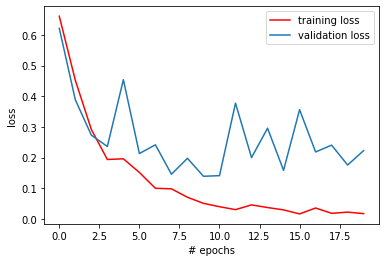

In [10]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

KeyError: 'validation_accuracy'

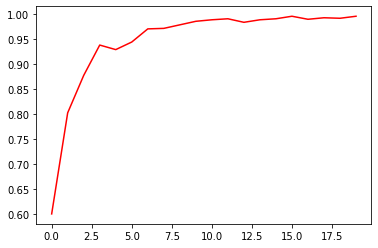

In [13]:
plt.plot(history.history['acc'],'r',label='training accuracy')
plt.plot(history.history['val_acc'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [21]:
final=model.save("model_mask.model")

In [22]:
print(model.evaluate(test_data,test_target))

138/138 [==============================] - 2s 12ms/step
[0.09393203209923662, 0.9710144996643066]


## Part 3:-Detecting Mask

In [23]:
from keras.models import load_model
import cv2
import numpy as np

In [24]:
model = load_model('model_mask.model')

face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

source=cv2.VideoCapture(0)

labels_dict={0:'MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [25]:
while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()